In [1]:
import os
import pydicom
import glob
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
def readDicom(path):
    print(os.path.basename(path))
    pi = os.path.basename(path).split('_')[1]
    dcm_size = len(glob.glob(path+'/*.dcm'))
    dcms = [path+'/E'+pi+'S101I%d.dcm'%dicom_slicei for dicom_slicei in range(1,dcm_size+1)]
    
    #读取dcm文档并且转换成numpy.ndarray格式
    dcm_f = pydicom.read_file(dcms[0]).pixel_array
    dcm_size = max(dcm_f.shape)
    
    #将一个案例中所有切片堆叠起来->h,w,s：(720, 720, 720)
    dcm_img = np.zeros((dcm_size,dcm_size,len(dcms)))
    for dcmi in range(len(dcms)):
        cdcm = pydicom.read_file(dcms[dcmi]).pixel_array
        dcm_img[dcm_size//2-cdcm.shape[0]//2:dcm_size//2+cdcm.shape[0]//2,
                dcm_size//2-cdcm.shape[1]//2:dcm_size//2+cdcm.shape[1]//2,dcmi] = cdcm
    return dcm_img


def listContourSlices(qvsroot):
    avail_slices = []
    
#   QVAS_Image是一个列表，长度=dcm_img.shape[2]
    qvasimg = qvsroot.findall('QVAS_Image')
#     print(qvasimg)
    for dicom_slicei in range(dcm_img.shape[2]):
        conts = qvasimg[dicom_slicei - 1].findall('QVAS_Contour')
#         print(conts)
        if len(conts):
            avail_slices.append(dicom_slicei)
    return avail_slices


def getContour(qvsroot,dicomslicei,conttype,dcmsz=720):
    qvasimg = qvsroot.findall('QVAS_Image')
    
    if dicomslicei - 1 > len(qvasimg):
        print('no slice', dicomslicei)
        return
    
    assert int(qvasimg[dicomslicei - 1].get('ImageName').split('I')[-1]) == dicomslicei
    
    # 特定的一个avial slice
    conts = qvasimg[dicomslicei - 1].findall('QVAS_Contour')
    
    tconti = -1
    for conti in range(len(conts)):
        if conts[conti].find('ContourType').text == conttype:
            tconti = conti
            break
    if tconti == -1:
        print('no such contour', conttype)
        return
    
    pts = conts[tconti].find('Contour_Point').findall('Point')
    contours = []
    for pti in pts:
        contx = float(pti.get('x')) / 512 * dcmsz 
        conty = float(pti.get('y')) / 512 * dcmsz 
        #if current pt is different from last pt, add to contours
        if len(contours) == 0 or contours[-1][0] != contx or contours[-1][1] != conty:
            contours.append([contx, conty])
    return np.array(contours)

E:\Win10_data\Segmentation\VMS_Unet\datasets\careIIChallenge/0_P125_U
0_P125_U
Dcm shape (720, 720, 720)
case P125 art ICAL avail_slices [291, 296, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 412, 417, 422, 427, 432, 437, 442, 447, 452, 457, 462, 467, 472, 477, 482, 487, 492, 497, 502, 507, 512, 517, 522, 527, 532, 537, 542, 547, 552, 557, 560]
Displaying the contours for the first slice for ICAL


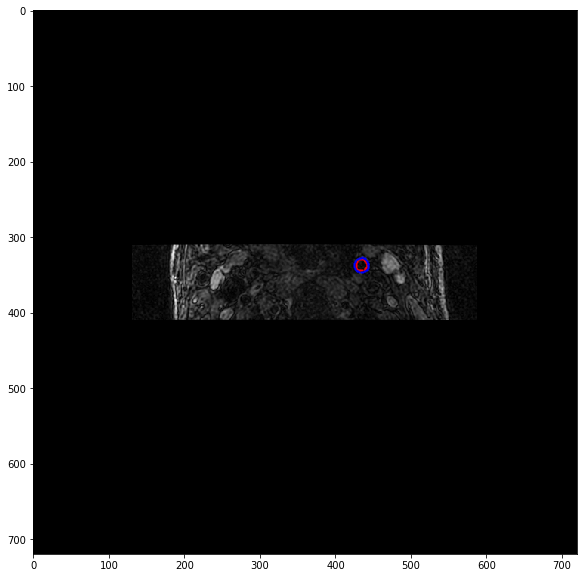

case P125 art ICAR avail_slices [281, 282, 283, 285, 288, 293, 298, 303, 308, 313, 318, 323, 327, 332, 335, 337, 342, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 501, 506, 511, 516, 521, 526, 531, 536, 541, 546, 551, 556, 561]
Displaying the contours for the first slice for ICAR


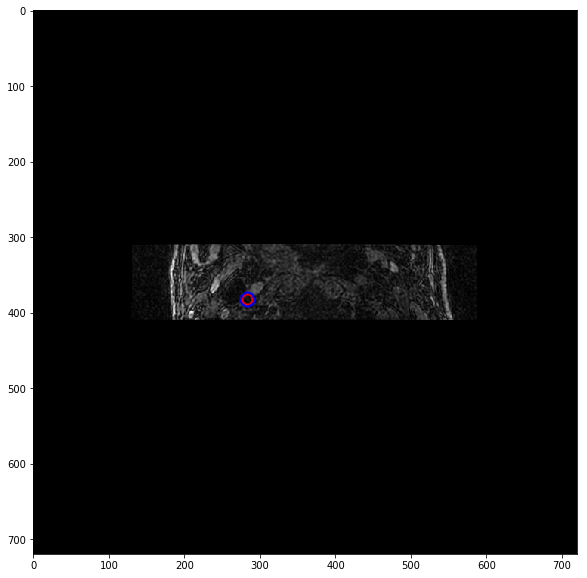

case P125 art ECAL avail_slices []
case P125 art ECAR avail_slices [292, 296, 301, 306, 311, 316, 321, 326]
Displaying the contours for the first slice for ECAR


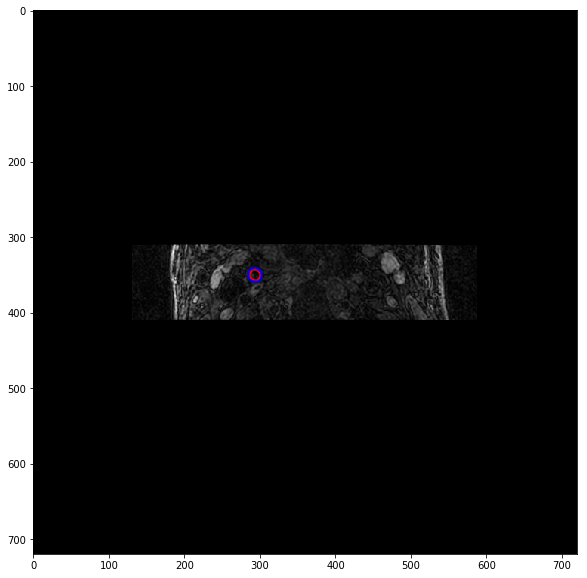

In [5]:
# cdir = 'D:/LiChen/careIIChallenge'
cdir = r'E:\Win10_data\Segmentation\VMS_Unet\datasets\careIIChallenge'
# print(os.listdir(cdir)[0])

for casei in os.listdir(cdir)[:1]:
    pi = casei.split('_')[1]
#     print(pi)
    print(cdir+'/'+casei)
    dcm_img = readDicom(cdir+'/'+casei)
#     print(dcm_img)
    
#     dcm_img = readDicom(cdir)
    print('Dcm shape',dcm_img.shape)
    
    for arti in ['ICAL','ICAR','ECAL','ECAR']:
        cas_dir = cdir+'/'+casei+'/CASCADE-'+arti
        qvs_path = cas_dir+'/E'+pi+'S101_L.QVS'
        qvsroot = ET.parse(qvs_path).getroot()
#         print(qvsroot)
        
        avail_slices = listContourSlices(qvsroot)
        print('case',pi,'art',arti,'avail_slices',avail_slices)
        
        if len(avail_slices):
            # dicom_slices：avail_slices的第一片序号
            dicom_slicei = avail_slices[0]
            print('Displaying the contours for the first slice for',arti)
            lumen_cont = getContour(qvsroot,dicom_slicei,'Lumen')
            wall_cont = getContour(qvsroot,dicom_slicei,'Outer Wall')
            
            plt.figure(figsize=(10,10))
            plt.imshow(dcm_img[:,:,dicom_slicei],cmap='gray')
            plt.plot(lumen_cont[:,0],lumen_cont[:,1],'ro',markersize=1)
            plt.plot(wall_cont[:,0],wall_cont[:,1],'bo',markersize=1)
            plt.show()